##### You are now ready to use Python and SQLAlchemy to do basic climate analysis and data exploration on your new weather station tables. All of the following analysis should be completed using SQLAlchemy ORM queries, Pandas, and Matplotlib.
-  Choose a start date & end date for your trip (make sure range is approx. 3-15 days total.
-  Use SQLAlchemy 'create_engine' to connect to sqlite database.
-  Use SQLAlchemy 'automap_base()' to reflect your tables into classes and save a reference to those classes called 'Station' and 'Measurement'.

In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('nbagg')
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, MetaData, Table
from sqlalchemy import Column, Date, Float, Integer, String

import datetime as dt

In [2]:
# 6/11/2017 ~ 6/18/2017
engine = create_engine("sqlite:///hawaii.sqlite", echo=False)

In [3]:
metadata = MetaData()
#print metadata.tables

metadata.reflect(bind=engine)
for table in metadata.tables.values():
    print(table.name)
    for column in table.c:
        print(column.name)

measurements
id
station
date
prcp
tobs
stations
id
station
name
latitude
longitude
elevation


In [4]:
inspector = inspect(engine)
inspector.get_table_names()

['measurements', 'stations']

In [5]:
engine.execute('Select * from measurements LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65),
 (2, 'USC00519397', '2010-01-02', 0.0, 63),
 (3, 'USC00519397', '2010-01-03', 0.0, 74),
 (4, 'USC00519397', '2010-01-04', 0.0, 76),
 (5, 'USC00519397', '2010-01-07', 0.06, 70)]

In [6]:
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurements', 'stations']

In [8]:
Measurement = Base.classes.measurements
Station = Base.classes.stations

session = Session(engine)

### Precipitation Analysis
-  Design a query to retrieve the last 12 months of precipitation data.

-  Select only the `date` and `prcp` values.

-  Load the query results into a Pandas DataFrame and set the index to the date column.

-  Plot the results using the DataFrame `plot` method.

    -  <center><img src='images/precip.png' /></center>

-  Use Pandas to print the summary statistics for the precipitation data.

<IPython.core.display.Javascript object>


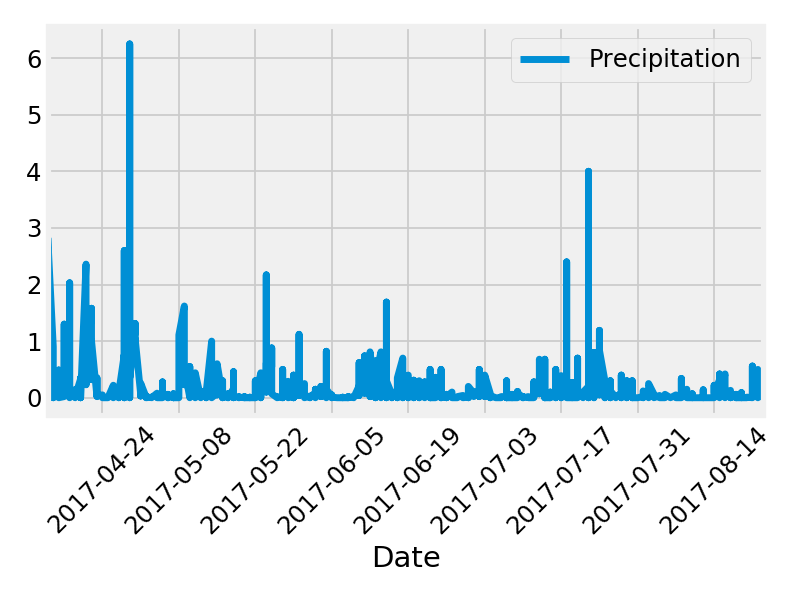

In [21]:
last_year_dt = dt.date.today() - dt.timedelta(days=365)

prcp_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > last_year_dt).all()

prcp_df = pd.DataFrame(prcp_data, columns = ["Date", "Precipitation"])
prcp_df.set_index(prcp_df["Date"], inplace = True)

prcp_df.plot()

plt.xticks(rotation = '45')
plt.tight_layout()
plt.show()

### Station Analysis

-  Design a query to calculate the total number of stations.

-  Design a query to find the most active stations.

    -  List the stations and observation counts in descending order

    -  Which station has the highest number of observations?

-  Design a query to retrieve the last 12 months of temperature observation data (tobs).

    -  Filter by the station with the highest number of observations.

    -  Plot the results as a histogram with `bins=12`.

  <center><img src='images/temp_hist.png' height="400px" /></center>

In [13]:
# Number of stations
session.query(func.count(Station.station)).all()

[(9)]

In [16]:
# Most active stations
active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [19]:
# Station with the highest no. of observations
active_stations[:1]

[('USC00519281', 2772)]

#### Temperature Observation Data

<IPython.core.display.Javascript object>


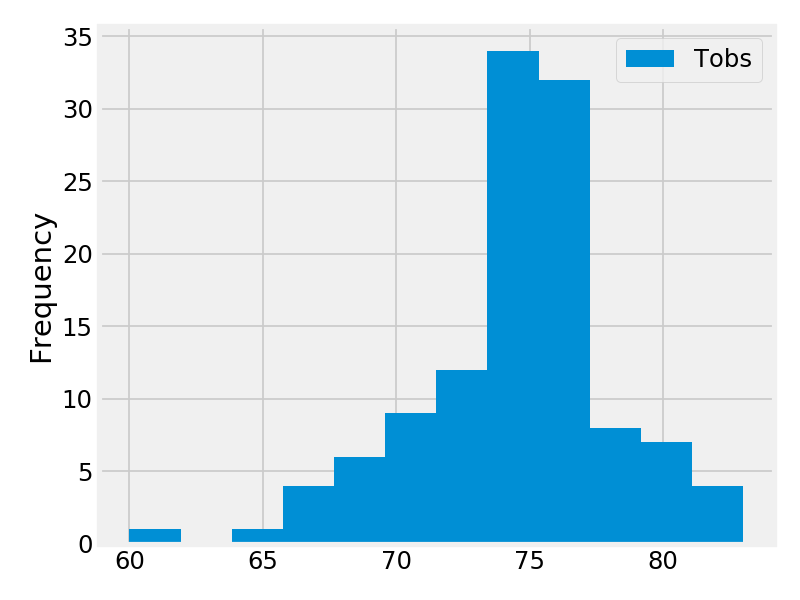

In [22]:
# Plot Tobs for station with highest no. of obs for the past 12 mos.
import datetime as dt
tobs_last_yr_dt = dt.date.today() - dt.timedelta(days = 365)

tobs_data = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date > tobs_last_yr_dt).all()
    
tobs_df = pd.DataFrame(tobs_data, columns = ['Tobs'])
tobs_df.plot.hist(bins = 12)
plt.tight_layout()
plt.show()

### Temperature Analysis

-  Write a function called `calc_temps` that will accept a start date and end date in the format `%Y-%m-%d` and return the minimum, average, and maximum temperatures for that range of dates.

-  Use the `calc_temps` function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e. use "2017-01-01" if your trip start date was "2018-01-01")

-  Plot the min, avg, and max temperature from your previous query as a bar chart.

    -  Use the average temperature as the bar height.

    -  Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

<center><img src='images/temp_avg.png' height="30px"/></center>

In [23]:
# define function `calc_temps` takes in start date and end date
# in the format %Y-%m-%d and return the minimum, average, 
# and maximum temperatures for that range of dates
def calc_temps (stt_dt, end_dt):
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs),
                        func.max(Measurement.tobs)).filter(Measurement.date > stt_dt).\
            filter(Measurement.date <= end_dt).all()

min_avg_max_temp = calc_temps('2016-06-15', '2016-06-29')
min_avg_max_temp


[(69, 75.93975903614458, 81)]

In [26]:
# Same time previous year
import datetime as dt

last_year_stt_dt = dt.date(2016, 6, 15) - dt.timedelta(days = 365)
last_year_end_dt = dt.date(2016, 6, 29) - dt.timedelta(days = 365)

min_temp, avg_temp, max_temp = calc_temps(last_year_stt_dt.strftime("%Y-%m-%d"),\
                                          last_year_end_dt.strftime("%Y-%m-%d"))[0]
print(min_temp, avg_temp, max_temp)

69 75.38461538461539 81


<IPython.core.display.Javascript object>


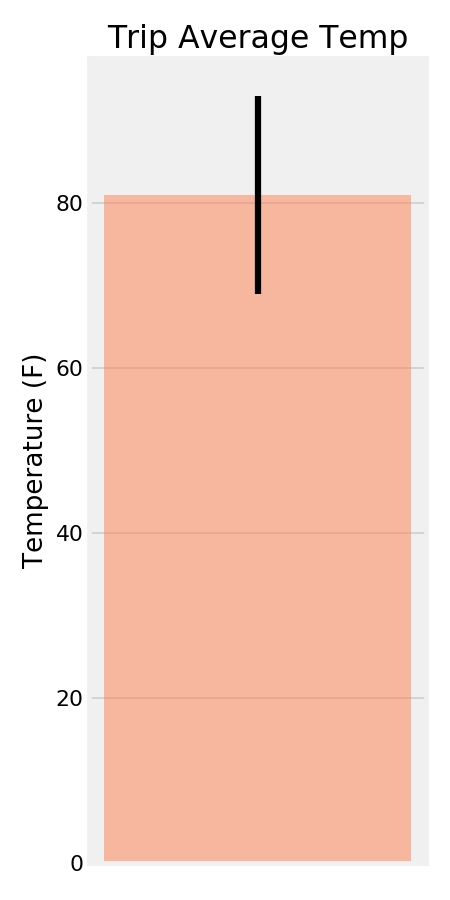

In [30]:
# Plot avg min max from previous query as bar chart
# Bar height is avg_temp
# yerr is max_temp - min_temp

fig, ax = plt.subplots(figsize = plt.figaspect(2.))
yerr = max_temp - min_temp

chart = ax.bar(1, max_temp, yerr = yerr, color = "coral", alpha = 0.5, align = "center")
ax.set(xticks = range(1), title = "Trip Average Temp", ylabel = "Temperature (F)")
fig.tight_layout()
fig.show()